In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [4]:
# Load the hash_master file
hash_df = pd.read_csv('../data/osstate/routes_hashes/hash_master.hash', header=None, names=['wpf', 'wpt', 'hash'])
print(f"There are {len(hash_df)} rows")
hash_df.head()

There are 38996 rows


,wpf,wpt,hash
0,yVYiw5LdGBHj,WtNfGYhU9NXD,f04422d69c87bf3e57775a2ab6f4_6f5
1,6CyC07jfLnnd,gjGUdQA4t348,f04422d69c87bf3e57775a2ab6f4_6f5
2,IejCrseQmSl7,op7JiDjB0ssO,e024375697c70f3417533aa637f4_6f5
3,BdqjF4kdoWuF,FEQqm0pwCiHB,06355708377841511e89a4d57999_8b3
4,Sqid2iRT6rsf,vcoAcE7pQ1gn,f04422569487bf3e57775a2ab6f4_6f5


In [5]:
hash_unique = hash_df['hash'].unique()
print('Number of unique hashes:', len(hash_unique))

Number of unique hashes: 65


In [6]:
# Rank the hashes by the number of times they appear
hash_counts = hash_df['hash'].value_counts()
hash_counts = hash_counts.sort_values(ascending=False)
hash_counts.head(10)


hash
0235571a176841711ec8a4c559dd_ffe    3485
8635571817e841751e89a4c579dd_8b3    3386
f04432569487bf3e57775a2ab7f4_6f5    3234
06355708377841511e89a4d57999_8b3    3064
f044a2d69c87bf3ed7775a2ab6f4_6f5    2646
06355708176841711e89a4c579d9_8b3    1896
8225571897e041751f09a4c779dd_8f3    1685
a225571e97c043751741a4877ddd_cf3    1642
06355718176841711e89a4c559dd_8b3    1627
8225571a97c041751f49a4c779dd_8f3    1572
Name: count, dtype: int64

In [7]:
# Load the waypoints_master file
wp_df = pd.read_csv('../data/osstate/waypoints_master.csv')
wp_df.head()

,ident,lat,lon
0,H882U2Xn5VOd,50.404884,-98.626030
1,P8ToOqoOwy3c,32.375521,130.663520
2,oZYSGKN80id2,41.086054,-77.855456
3,uPuRzZYavxw1,40.908554,-78.007263
4,lEf9PODPqPxe,40.573301,-78.509674


In [8]:
# df corresponding to the first hash value
hash_df1 = hash_df[hash_df['hash'] == hash_counts.index[1]]
print(f'There are {len(hash_df1)} rows for this hash pattern')
# sample randomly 100 rows
if len(hash_df1) > 100:
    hash_df1 = hash_df1.sample(100)
hash_df1.head()

There are 3386 rows for this hash pattern


,wpf,wpt,hash
19819,hX6yG042Clyk,2WxZ1jMDjefj,8635571817e841751e89a4c579dd_8b3
905,GfljkGDzjGRz,Yi03thvLeJWo,8635571817e841751e89a4c579dd_8b3
21851,C4RKG6KCX1TJ,EuwqOt800KIX,8635571817e841751e89a4c579dd_8b3
19799,UGu9JyHN8Ee6,kyAOex5z8oPg,8635571817e841751e89a4c579dd_8b3
6998,OGXq3PVlutcI,XHKir5Ibe8mf,8635571817e841751e89a4c579dd_8b3


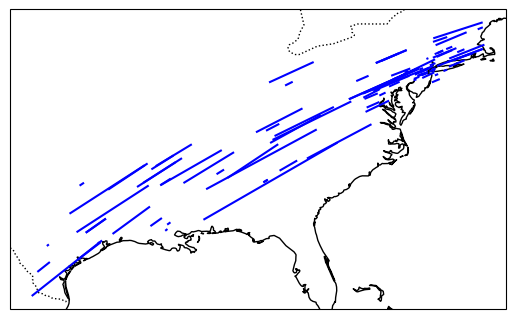

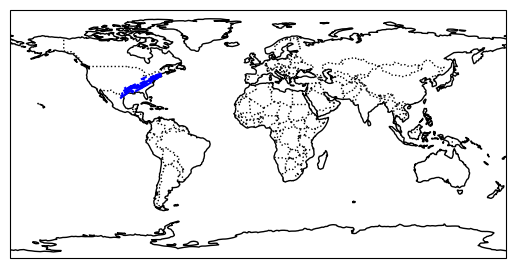

In [9]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy

def plot_segments(hash_df, wp_df, globe=False):
    
    # Create a Cartopy PlateCarree projection
    projection = ccrs.PlateCarree()

    # Create a figure and axis with the PlateCarree projection
    fig, ax = plt.subplots(subplot_kw={'projection': projection})

    # Get the waypoints
    wpf = hash_df['wpf'].values
    wpt = hash_df['wpt'].values

    # For each wpf, get the longitude and latitude
    for i in range(len(wpf)):
        wpf_lon = wp_df[wp_df['ident'] == wpf[i]]['lon'].values[0]
        wpf_lat = wp_df[wp_df['ident'] == wpf[i]]['lat'].values[0]
        wpt_lon = wp_df[wp_df['ident'] == wpt[i]]['lon'].values[0]
        wpt_lat = wp_df[wp_df['ident'] == wpt[i]]['lat'].values[0]

        # Plot the segment
        ax.plot([wpf_lon, wpt_lon], [wpf_lat, wpt_lat], 'b', transform=projection)


    # Add map features
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

    # Set the extent of the map
    if globe:
        ax.set_extent([-180, 180, -90, 90])

    # Show the plot
    plt.show()

plot_segments(hash_df1, wp_df, globe=False)
plot_segments(hash_df1, wp_df, globe=True)